# Accessing release 2.0 of the Chandra Source Catalog with PyVO and CIAO tools, with basic science applications using astropy and scikit-learn 
### Original notebook by Doug Burke, expanded by Rafael Martinez-Galarza

The [PyVo](https://pyvo.readthedocs.io/) package allows users to query Virtual Observatory services from Python. In this notebook we show how you can use it to query [release 2.0 of the Chandra Source Catalog](https://cxc.cfa.harvard.edu/csc2/) using the [VO interfaces](https://cxc.harvard.edu/csc/download.html#vo) for tabulated properties, and [CIAO](https://cxc.cfa.harvard.edu/ciao/) tools to retrieve catalog data products. We also show how to use [astropy](https://www.astropy.org/) to perform cross-matches with other catalogs, and some basic applications in machine learning with [scikit-learn](https://scikit-learn.org/stable/)

This notebook assumes you have installed CIAO 4.13 using conda, but you should also be able to do this with a CIAO installed using the `ciao-install` script, or any other Python environment as we are just going to use [Astropy](https://www.astropy.org/) along with `pyvo`. The `pyyaml` poackage is needed to support writing out the file (it avoids a warning message you would get).

Packages to install:

 - `pip install astropy pyvo pyyaml matplotlib`

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib

import astropy
import pyvo as vo

import scipy

%matplotlib inline

Let's just check the versions (it is expected that the results should not depend on these versions):

In [2]:
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyVO        - {vo.__version__}")

Versions:
  NumPy       - 1.19.1
  Matplotlib  - 3.3.1
  AstroPy     - 4.0.1.post1
  PyVO        - 1.1


## Aim

This document will show you how to:

* Use a cone search - that is, find results around a given location - and then run a general "database query", which can be done over the whole sky. The Virtual Observatory cone-search interface is "simple", in that you give it a location, radius, and an optional "verbosity" parameter between 1 and 3, inclusive, that controls the number of columns that gets returned. The details can be found at the [CSC 2.0 cone search](http://cda.cfa.harvard.edu/cscvo/) page.

* Use the Table Access Protocol (TAP) service, for performing specific queries of CSC2 tables, allowing much-more general queries. It is suggested that you use [CSCView](http://cda.harvard.edu/cscview/) to create a query, and then view the query - using the `View/Query/Show Language` menu item - to see what query it has created: this is important for complex queries where you are trying to access data from multiple tables (e.g. observation-level fluxes mapped to a given master source), since there are many "hidden" traps in these queries which CSCView knows about.

* Cross-match the CSC2 catalog with other catalogs, and visualize the results.

* Download data products from the CSC2, such as light curves and spectra, and visualize them for science applications.

* Input CSC2 data to a machine learning algorithm.

## Cone Search

Let's start with using cone search in order to find CSC2 near the M33 galaxy. Cone search will only query the maste level tables (you need to use TAP interfaces, see below, to query per-obsid properties). We will use a search radius of 1 degree. We will use the name resolver from Astropy. Here is a visualization of the CSC2 sources in this area, from [ESASky](https://sky.esa.int/):

![M33](m33.png)


In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u

m33 = SkyCoord.from_name('M33')
maxrad = 1.0 * u.deg

In [4]:
m33

<SkyCoord (ICRS): (ra, dec) in deg
    (23.4621, 30.65994167)>

We now need a Python object representing the 
[CSC2 Virtual Observatory Cone Search Service](http://cda.cfa.harvard.edu/cscvo/), which has a base URL of `http://cda.cfa.harvard.edu/csc2scs/coneSearch`:

In [5]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

To run the search we are going to use the `search` method, which (fortunately for this notebook) has a short help page so I can include it:

In [6]:
help(cone.search)

Help on method search in module pyvo.dal.scs:

search(pos, radius=1.0, verbosity=2, **keywords) method of pyvo.dal.scs.SCSService instance
    submit a simple Cone Search query that requests objects or observations
    whose positions fall within some distance from a search position.
    
    Parameters
    ----------
    pos : astropy.coordinates.SkyCoord
        a SkyCoord instance defining the position of the center of the
        circular search region.
        converted if it's a iterable containing scalars,
        assuming icrs degrees.
    radius : `~astropy.units.Quantity` or float
        a Quantity instance defining the radius of the circular search
        region, in degrees.
        converted if it is another unit.
    verbosity : int
       an integer value that indicates the volume of columns
       to return in the result table.  0 means the minimum
       set of columns, 3 means as many columns as are available.
    **keywords :
       additional case insensitive param

We can then run the query with the following (the arguments don't need to be named but it makes things a bit clearer to be explicit):

In [7]:
results = cone.search(pos=m33, radius=maxrad, verbosity=3)

Hopefully this completes without error, and returns 750 results (note that it depends on the location returned by the name search and so can change when the SIMBAD or NED results change):

In [8]:
len(results)

750

In [9]:
results

<Table length=750>
         name                 ra         ... hrc_hetg_time hrc_letg_time
                             deg         ...       s             s      
        object             float64       ...    float64       float64   
--------------------- ------------------ ... ------------- -------------
2CXO J013159.9+303500  22.99991954305341 ...            --            --
2CXO J013202.9+303445  23.01219298372888 ...            --            --
2CXO J013203.1+303841 23.012944925258978 ...            --            --
2CXO J013205.9+302305  23.02473533826901 ...            --            --
2CXO J013215.7+304008  23.06568844810522 ...            --            --
2CXO J013217.5+302555  23.07332419514978 ...            --            --
2CXO J013217.9+301933 23.074814699111812 ...            --            --
2CXO J013220.0+303450  23.08344394730176 ...            --            --
2CXO J013220.0+303640 23.083592126140672 ...            --            --
                  ...           

The fact that the source names begin with '2CXO' means that we are indeed searching release 2.0 and not 1.1. Let's see what the default columns are (note that this search was run with the cone-search `verbosity` parameter set to 3, which http://cda.cfa.harvard.edu/cscvo/ tells us returns all CSC columns at the master level.

The results can be converted to an AstroPy table - using `results.to_table()`, which we use below - but they can also be used directly:

In [10]:
# Let's print the first 50 fields
results.fieldnames[0:50]

('name',
 'ra',
 'dec',
 'err_ellipse_r0',
 'err_ellipse_r1',
 'err_ellipse_ang',
 'gal_b',
 'gal_l',
 'extent_flag',
 'conf_flag',
 'pileup_flag',
 'var_flag',
 'streak_src_flag',
 'sat_src_flag',
 'man_add_flag',
 'man_inc_flag',
 'man_reg_flag',
 'man_match_flag',
 'man_pos_flag',
 'var_inter_hard_flag',
 'major_axis_b',
 'major_axis_h',
 'major_axis_m',
 'major_axis_s',
 'major_axis_u',
 'major_axis_w',
 'major_axis_lolim_b',
 'major_axis_lolim_h',
 'major_axis_lolim_m',
 'major_axis_lolim_s',
 'major_axis_lolim_u',
 'major_axis_lolim_w',
 'major_axis_hilim_b',
 'major_axis_hilim_h',
 'major_axis_hilim_m',
 'major_axis_hilim_s',
 'major_axis_hilim_u',
 'major_axis_hilim_w',
 'minor_axis_b',
 'minor_axis_h',
 'minor_axis_m',
 'minor_axis_s',
 'minor_axis_u',
 'minor_axis_w',
 'minor_axis_lolim_b',
 'minor_axis_lolim_h',
 'minor_axis_lolim_m',
 'minor_axis_lolim_s',
 'minor_axis_lolim_u',
 'minor_axis_lolim_w')

In [11]:
# Print the first 50 entries
results['name'][0:50]

masked_array(data=[b'2CXO J013159.9+303500', b'2CXO J013202.9+303445',
                   b'2CXO J013203.1+303841', b'2CXO J013205.9+302305',
                   b'2CXO J013215.7+304008', b'2CXO J013217.5+302555',
                   b'2CXO J013217.9+301933', b'2CXO J013220.0+303450',
                   b'2CXO J013220.0+303640', b'2CXO J013221.0+304500',
                   b'2CXO J013223.4+304746', b'2CXO J013224.4+303322',
                   b'2CXO J013224.9+304510', b'2CXO J013227.2+303520',
                   b'2CXO J013228.9+304516', b'2CXO J013229.2+303617',
                   b'2CXO J013230.2+304216', b'2CXO J013230.3+303547',
                   b'2CXO J013230.4+303618', b'2CXO J013231.6+301726',
                   b'2CXO J013232.5+302623', b'2CXO J013232.6+304028',
                   b'2CXO J013233.6+304728', b'2CXO J013233.9+302112',
                   b'2CXO J013236.8+303228', b'2CXO J013237.2+301807',
                   b'2CXO J013239.6+302126', b'2CXO J013240.6+303722',
      

We can iterate through the sources, and print, for example, their aperture photometry fluxes in the b band, and their limits, only for sources that have a significance (or signal to noise ratio) larger than 50:

In [12]:
for r in results:
    if (r['significance']>50.0):
        out = f"{r['name']} flux={r['flux_aper_b']:.3e}  "
        out += f"{r['flux_aper_lolim_b']:.3e} - {r['flux_aper_hilim_b']:.3e}"
        print(out)

b'2CXO J013311.7+303841' flux=1.467e-13  1.444e-13 - 1.488e-13
b'2CXO J013315.1+305318' flux=1.331e-12  1.318e-12 - 1.344e-12
b'2CXO J013324.4+304402' flux=7.953e-13  7.838e-13 - 8.061e-13
b'2CXO J013328.6+302723' flux=2.681e-12  2.660e-12 - 2.701e-12
b'2CXO J013334.1+303211' flux=7.751e-13  7.595e-13 - 7.908e-13
b'2CXO J013350.9+303936' flux=1.422e-11  1.417e-11 - 1.427e-11
b'2CXO J013425.8+305518' flux=3.005e-13  2.939e-13 - 3.072e-13
b'2CXO J013451.8+302909' flux=2.094e-12  2.071e-12 - 2.116e-12


Let's display the location on the sky of these sources, and color code by significance:

Text(0, 0.5, 'log(significance)')

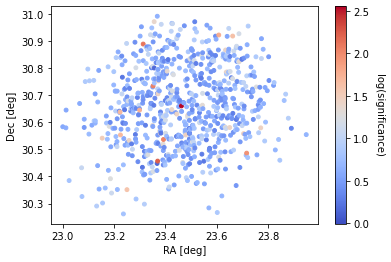

In [13]:
#plt.plot(results['ra'], results['dec'], 'o');

from matplotlib import cm
import matplotlib.colors as colors
cmap = cm.coolwarm
normalize = matplotlib.colors.Normalize(vmin=np.min(np.log10(results['significance'].data)), 
                                        vmax=np.max(np.log10(results['significance'].data)))
plt.scatter(results['ra'],results['dec'],cmap=cmap,norm=normalize,c=np.log10(results['significance'].data),s=15)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
#plt.ylim(-0.98,0.98)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(significance)', rotation=270)

Now let's simultaneously visualize the spectral and variability probabilities of these sources by plotting the hardness ratios, and color coding them by variability probability, both at short timescales (intra-observation variability), and long timescales (inter-observation variability):

Text(0.5, 1.0, 'Long term variability')

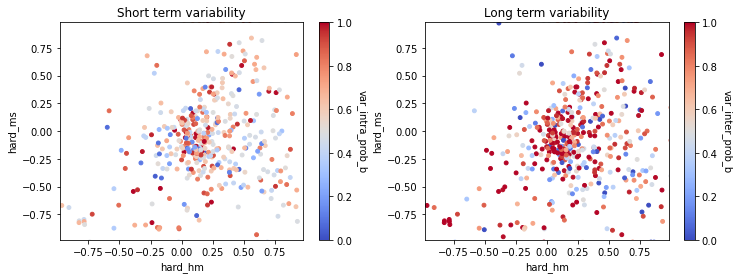

In [15]:
from matplotlib import cm
import matplotlib.colors as colors

plt.subplots(figsize=(12, 4))
cmap = cm.coolwarm
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.subplot(1,2,1)
plt.scatter(results['hard_hm'],results['hard_ms'],cmap=cmap,norm=normalize,c=results['var_intra_prob_b'].data,s=15)
plt.xlim(-0.98,0.98)
plt.ylim(-0.98,0.98)
cbar = plt.colorbar()
plt.xlabel('hard_hm')
plt.ylabel('hard_ms')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('var_intra_prob_b', rotation=270)
plt.title('Short term variability')
plt.subplot(1,2,2)
plt.scatter(results['hard_hm'],results['hard_ms'],cmap=cmap,norm=normalize,c=results['var_inter_prob_b'].data,s=15)
plt.xlim(-0.98,0.98)
plt.ylim(-0.98,0.98)
cbar = plt.colorbar()
plt.xlabel('hard_hm')
plt.ylabel('hard_ms')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('var_inter_prob_b', rotation=270)
plt.title('Long term variability')

### Saving data

Let's try to save the search results as a FITS table. Unfortunately for us the name column
is being turned into a Python object rather than a string, which causes the conversion to FITS to fail. This
appears to be a choice with how AstroPy [handles string columns of unrestricted length](https://docs.astropy.org/en/stable/io/votable/#datatype-mappings), so one solution is to manually convert the name field to string values.

In [16]:
results.votable.get_field_by_id_or_name('name')

<FIELD ID="name" arraysize="*" datatype="char" name="name"/>

In [17]:
tbl = results.to_table()

The `name` column starts out as having a data type of `object` (as the string names are normally 21 characters long but can be 22).

A quick conversion is to just use `str`:

In [18]:
tbl['name'] = [str(n) for n in tbl['name']]

The output for a AstroPy Table is slightly different:

In [19]:
tbl

name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,gal_b,gal_l,extent_flag,conf_flag,pileup_flag,var_flag,streak_src_flag,sat_src_flag,man_add_flag,man_inc_flag,man_reg_flag,man_match_flag,man_pos_flag,var_inter_hard_flag,major_axis_b,major_axis_h,major_axis_m,major_axis_s,major_axis_u,major_axis_w,major_axis_lolim_b,major_axis_lolim_h,major_axis_lolim_m,major_axis_lolim_s,major_axis_lolim_u,major_axis_lolim_w,major_axis_hilim_b,major_axis_hilim_h,major_axis_hilim_m,major_axis_hilim_s,major_axis_hilim_u,major_axis_hilim_w,minor_axis_b,minor_axis_h,minor_axis_m,minor_axis_s,minor_axis_u,minor_axis_w,minor_axis_lolim_b,minor_axis_lolim_h,minor_axis_lolim_m,minor_axis_lolim_s,minor_axis_lolim_u,minor_axis_lolim_w,minor_axis_hilim_b,minor_axis_hilim_h,minor_axis_hilim_m,minor_axis_hilim_s,minor_axis_hilim_u,minor_axis_hilim_w,pos_angle_b,pos_angle_h,pos_angle_m,pos_angle_s,pos_angle_u,pos_angle_w,pos_angle_lolim_b,pos_angle_lolim_h,pos_angle_lolim_m,pos_angle_lolim_s,pos_angle_lolim_u,pos_angle_lolim_w,pos_angle_hilim_b,pos_angle_hilim_h,pos_angle_hilim_m,pos_angle_hilim_s,pos_angle_hilim_u,pos_angle_hilim_w,src_area_b,src_area_h,src_area_m,src_area_s,src_area_u,src_area_w,phot_nsrcs,photflux_aper_b,photflux_aper_h,photflux_aper_m,photflux_aper_s,photflux_aper_u,photflux_aper_w,photflux_aper_lolim_b,photflux_aper_lolim_h,photflux_aper_lolim_m,photflux_aper_lolim_s,photflux_aper_lolim_u,photflux_aper_lolim_w,photflux_aper_hilim_b,photflux_aper_hilim_h,photflux_aper_hilim_m,photflux_aper_hilim_s,photflux_aper_hilim_u,photflux_aper_hilim_w,photflux_aper90_b,photflux_aper90_h,photflux_aper90_m,photflux_aper90_s,photflux_aper90_u,photflux_aper90_w,photflux_aper90_lolim_b,photflux_aper90_lolim_h,photflux_aper90_lolim_m,photflux_aper90_lolim_s,photflux_aper90_lolim_u,photflux_aper90_lolim_w,photflux_aper90_hilim_b,photflux_aper90_hilim_h,photflux_aper90_hilim_m,photflux_aper90_hilim_s,photflux_aper90_hilim_u,photflux_aper90_hilim_w,flux_aper_b,flux_aper_h,flux_aper_m,flux_aper_s,flux_aper_u,flux_aper_w,flux_aper_lolim_b,flux_aper_lolim_h,flux_aper_lolim_m,flux_aper_lolim_s,flux_aper_lolim_u,flux_aper_lolim_w,flux_aper_hilim_b,flux_aper_hilim_h,flux_aper_hilim_m,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_w,flux_aper90_b,flux_aper90_h,flux_aper90_m,flux_aper90_s,flux_aper90_u,flux_aper90_w,flux_aper90_lolim_b,flux_aper90_lolim_h,flux_aper90_lolim_m,flux_aper90_lolim_s,flux_aper90_lolim_u,flux_aper90_lolim_w,flux_aper90_hilim_b,flux_aper90_hilim_h,flux_aper90_hilim_m,flux_aper90_hilim_s,flux_aper90_hilim_u,flux_aper90_hilim_w,photflux_aper_avg_b,photflux_aper_avg_h,photflux_aper_avg_m,photflux_aper_avg_s,photflux_aper_avg_u,photflux_aper_avg_w,photflux_aper_avg_lolim_b,photflux_aper_avg_lolim_h,photflux_aper_avg_lolim_m,photflux_aper_avg_lolim_s,photflux_aper_avg_lolim_u,photflux_aper_avg_lolim_w,photflux_aper_avg_hilim_b,photflux_aper_avg_hilim_h,photflux_aper_avg_hilim_m,photflux_aper_avg_hilim_s,photflux_aper_avg_hilim_u,photflux_aper_avg_hilim_w,photflux_aper90_avg_b,photflux_aper90_avg_h,photflux_aper90_avg_m,photflux_aper90_avg_s,photflux_aper90_avg_u,photflux_aper90_avg_w,photflux_aper90_avg_lolim_b,photflux_aper90_avg_lolim_h,photflux_aper90_avg_lolim_m,photflux_aper90_avg_lolim_s,photflux_aper90_avg_lolim_u,photflux_aper90_avg_lolim_w,photflux_aper90_avg_hilim_b,photflux_aper90_avg_hilim_h,photflux_aper90_avg_hilim_m,photflux_aper90_avg_hilim_s,photflux_aper90_avg_hilim_u,photflux_aper90_avg_hilim_w,flux_aper_avg_b,flux_aper_avg_h,flux_aper_avg_m,flux_aper_avg_s,flux_aper_avg_u,flux_aper_avg_w,flux_aper_avg_lolim_b,flux_aper_avg_lolim_h,flux_aper_avg_lolim_m,flux_aper_avg_lolim_s,flux_aper_avg_lolim_u,flux_aper_avg_lolim_w,flux_aper_avg_hilim_b,flux_aper_avg_hilim_h,flux_aper_avg_hilim_m,flux_aper_avg_hilim_s,flux_aper_avg_hilim_u,flux_aper_avg_hilim_w,flux_aper90_avg_b,flux_aper90_avg_h,flux_aper90_avg_m,flux_aper90_avg_s,flux_aper90_avg_u,flux_aper90_avg_w,flux_aper90_avg_lolim_b,flux_aper90_avg_lolim_h,flux_aper9

Finally the file can be written out as a FITS table:

In [22]:
tbl.write('m33.fits', format='fits', overwrite=True)

## Moving to TAP queries (general queries)

For an all-sky search we are going to switch to the [Table Access Protocol](http://cda.cfa.harvard.edu/csctap/) search. This has a base URL of `http://cda.cfa.harvard.edu/csc2tap` and requires us writing a query using the [Astronomical Data Query Language (ADQL)](https://wiki.ivoa.net/twiki/bin/view/IVOA/ADQL). In this particular case, we are going to do a simple search and return a subset of the columns that we got back from the cone search:

```
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_b, m.flux_aper_lolim_b, m.flux_aper_hilim_b
FROM csc2.master_source m
WHERE m.name LIKE '%X'
```

In [20]:
tap = vo.dal.TAPService('http://cda.cfa.harvard.edu/csc2tap')

We can check what tables are available (although we are focussed on the "master source" table, it's useful to know what else is available):

In [21]:
for i, tblname in enumerate(tap.tables.keys()):
    print(f"{i + 1:2d} - {tblname}")

 1 - TAP_SCHEMA.schemas
 2 - TAP_SCHEMA.tables
 3 - TAP_SCHEMA.columns
 4 - TAP_SCHEMA.keys
 5 - TAP_SCHEMA.key_columns
 6 - csc2.master_source
 7 - csc2.stack_source
 8 - csc2.observation_source
 9 - csc2.master_stack_assoc
10 - csc2.stack_observation_assoc
11 - csc2.detect_stack
12 - csc2.valid_stack
13 - csc2.likely_stack
14 - csc2.cross_match
15 - csc2.cone
16 - csc2.image
17 - ivoa.ObsCore


### Extended sources
Let's try the simple query. This asks for master-source properties on all the "extended" sources in the catalog (where "extended" means large-diffuse emission, and not slightly-larger-than-a-point-source extended):

In [22]:
qry = """
SELECT m.name, m.ra, m.dec, m.conf_flag, m.significance, m.extent_flag, m.sat_src_flag,
       m.flux_aper_avg_b, m.flux_aper_avg_lolim_b, m.flux_aper_avg_hilim_b
FROM csc2.master_source m
WHERE m.name LIKE '%X'
"""

In [23]:
tresults = tap.search(qry)

In CSC2 there are 1299 extended master sources:

In [24]:
len(tresults)

1299

In [25]:
fluxes_ext = tresults['flux_aper_avg_b']
fluxes_ext1 = fluxes_ext[fluxes_ext>0]

Let's check the sky distribution and the fluxes for these extended sources, which should cover most of the sky (excluding poles and a band close to the plane):

-15.214243682432903 -7.35735093518183


Text(0, 0.5, 'log(F$_X$) [erg/s/cm$^2$]')

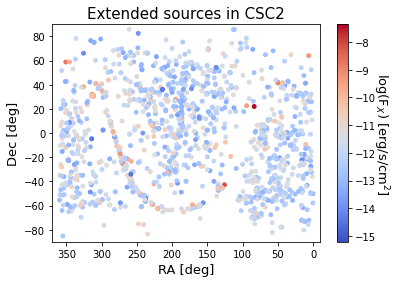

In [26]:
#plt.plot(tresults['ra'], tresults['dec'], 'o')
plt.title('Extended sources in CSC2')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.ylim(-90, 90)
plt.xlim(370, -10);



min_norm = np.min(np.log10(fluxes_ext1))
max_norm = np.max(np.log10(fluxes_ext1))

print(min_norm,max_norm)

normalize = matplotlib.colors.Normalize(vmin=min_norm, 
                                        vmax=max_norm)
plt.scatter(tresults['ra'][fluxes_ext>0],tresults['dec'][fluxes_ext>0],cmap=cmap,norm=normalize,
            c=np.log10(tresults['flux_aper_avg_b'].data[fluxes_ext>0]),s=15)
plt.xlabel('RA [deg]',size=13)
plt.ylabel('Dec [deg]',size=13)
plt.title('Extended sources in CSC2',size=15)
plt.ylim(-90, 90)
plt.xlim(370, -10);
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(F$_X$) [erg/s/cm$^2$]', rotation=270,size=13)

### Per-obsid search
Let's now try a search of the entire catalog for source detections that have significance larger than 10, and that are not flagged for saturation of for streaks. Let's also select detections that are uniquely associated with a master source. We will explore the distributions of the short term variability for these sources

In [27]:
qry = """
SELECT DISTINCT m.name,m.ra,m.dec,m.err_ellipse_r0,m.err_ellipse_r1,m.err_ellipse_ang,
    m.likelihood_class,a.match_type,o.obsid,o.obi,o.region_id,o.theta,o.phi,o.flux_significance_b,
    o.likelihood_b,o.conf_code,o.dither_warning_flag,o.extent_code,o.sat_src_flag,o.streak_src_flag,
    o.var_code,o.flux_aper_b,o.flux_aper_lolim_b,o.flux_aper_hilim_b,o.var_index_b,o.var_index_h,
    o.var_index_m,o.var_index_s,o.var_index_u,o.var_prob_b,o.var_prob_h,o.var_prob_m,o.var_prob_s,
    o.var_prob_u,o.ks_prob_b,o.ks_prob_h,o.ks_prob_m,o.ks_prob_s,o.ks_prob_u,o.var_sigma_b,
    o.var_sigma_h,o.var_sigma_m,o.var_sigma_s,o.var_sigma_u,o.var_mean_b,o.var_mean_h,
    o.var_mean_m,o.var_mean_s,o.var_mean_u,o.var_min_b,o.var_min_h,o.var_min_m,o.var_min_s,
    o.var_min_u,o.var_max_b,o.var_max_h,o.var_max_m,o.var_max_s,o.var_max_u 
FROM csc2.master_source m , csc2.master_stack_assoc a , csc2.observation_source o , 
    csc2.stack_observation_assoc b , csc2.stack_source s 
WHERE ((a.match_type = 'u') AND (o.flux_significance_b > 10) AND (o.sat_src_flag = 0) 
    AND (o.streak_src_flag = 0)) AND (m.name = a.name) 
    AND (s.detect_stack_id = a.detect_stack_id and s.region_id = a.region_id) 
    AND (s.detect_stack_id = b.detect_stack_id and s.region_id = b.region_id) 
    AND (o.obsid = b.obsid and o.obi = b.obi and o.region_id = b.region_id)
ORDER BY name ASC
"""

In [28]:
%time cat = tap.search(qry)

CPU times: user 10.2 s, sys: 298 ms, total: 10.5 s
Wall time: 44.3 s


In [29]:
len(cat)

31802

We get about 31,000 results, which is fortunately less than the maximum number of rows you can make in a query against this service (as shown by the `maxrec` parameter):

In [30]:
tap.maxrec

1000000

Let's have a look at the distributions of significance and variability for these sources. 

(1e-11, 10.0)

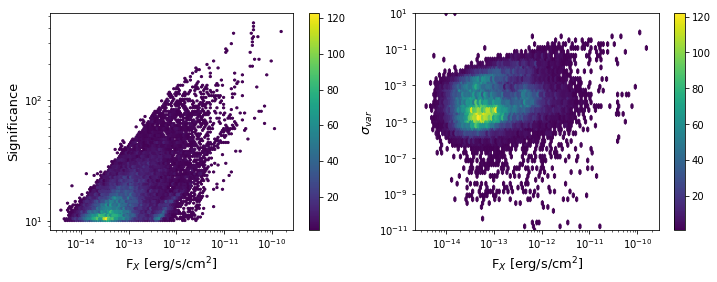

In [31]:
plt.subplots(figsize=(12, 4))
plt.subplot(1,2,1)
idx = (cat['flux_aper_b'] > 0) & (cat['flux_significance_b'] > 0)
plt.hexbin(cat['flux_aper_b'][idx], cat['flux_significance_b'][idx],
           xscale='log', yscale='log', mincnt=1)
plt.colorbar()
plt.xlabel('F$_X$ [erg/s/cm$^2$]',size=13)
plt.ylabel('Significance',size=13);
plt.subplot(1,2,2)
idx = (cat['flux_aper_b'] > 0) & (cat['var_sigma_b'] > 0)
plt.hexbin(cat['flux_aper_b'][idx], cat['var_sigma_b'][idx],
           xscale='log', yscale='log', mincnt=1)
plt.colorbar()
plt.xlabel('F$_X$ [erg/s/cm$^2$]',size=13)
plt.ylabel('$\sigma_{var}$',size=13);
plt.ylim(1e-11,1e1)

So we see that there at the level of individual observation detections, sgnificance and flux are correlated. The dispersion in significance for a give flux has to do with the background level and the off-axis angle of the detection. We also see that at a given flux there is a range of variability sigmas. Those with larger values are those with larger variations in the light curve with respect to the mean flux.


### Retrieving and displaying data products (light curves and spectra)
Let's now select a variable detection and obtain its light curve from the catalog. We can use CIAO tools for this, in particular, [*search_csc*](https://cxc.cfa.harvard.edu/ciao/ahelp/search_csc.html). Please note that using *search_csc* for bulk downloads (for example, download all catalog light curves) can saturate the server. For bulk downloads, users should issue a ["Special Request"](https://cxc.cfa.harvard.edu/cgi-gen/cda/specreq) to the Chandra Data Archive.

In [32]:
from ciao_contrib.runtool import search_csc

First, let's print some detections (and the corresponding source name and coordinates) that have fluxes larger than 5E-13 erg/s/cm2 and var_sigma_b larger than 1E-3. Additionally, let's select detections that are close to on-axis, using the off-axis angle *theta*, which is given in arcmin:

In [33]:
index = (cat['flux_aper_b']>5E-13) & (cat['flux_aper_b']<1E-12) & (cat['var_sigma_b']>1E-3) & (cat['theta'] < 3)
print('name,  obsid,  region_id, ra,  dec')
for i in range(20):
    print(cat['name'][index].data[i],
         cat['obsid'][index].data[i],
         cat['region_id'][index].data[i],
         cat['ra'][index].data[i],
         cat['dec'][index].data[i])

name,  obsid,  region_id, ra,  dec
b'2CXO J002404.2-720457' 78 58 6.01784253506969 -72.08276437373436
b'2CXO J002404.2-720457' 3384 129 6.01784253506969 -72.08276437373436
b'2CXO J002404.2-720457' 2735 129 6.01784253506969 -72.08276437373436
b'2CXO J004231.1+411621' 14197 115 10.629760440205644 41.27266631918941
b'2CXO J004231.1+411621' 15327 138 10.629760440205644 41.27266631918941
b'2CXO J004231.1+411621' 4720 138 10.629760440205644 41.27266631918941
b'2CXO J004231.1+411621' 8194 138 10.629760440205644 41.27266631918941
b'2CXO J004238.6+411603' 4722 478 10.66086581188398 41.26767223862725
b'2CXO J004239.5+411614' 1575 370 10.664987223146795 41.27062180613111
b'2CXO J004239.9+411547' 13300 111 10.666646569143893 41.263199005670494
b'2CXO J004242.5+405152' 1580 4 10.677263218723112 40.864543113379995
b'2CXO J004242.5+405152' 5690 23 10.677263218723112 40.864543113379995
b'2CXO J004245.1+411621' 14930 429 10.687979346386953 41.27268204164101
b'2CXO J004246.9+411615' 15267 487 10.6956748

*search_csc* can only perform a coordinate based search (or the name of a SIMBAD-recognized object). So, let's pick the first source, and do a search around its location with a search radius of 1 arcsec. We will request the light curve ('lc') for the broad band, as well as the spectral files (pha, arf, rmf). The command will also provide a table (source_search.tsv) with a summary of catalog properties for the retrieved sources (in this case, a single source).

In [34]:
search_csc('6.01784, -72.08276', '1', 'source_search.tsv', 'arcsec', 
           '', '', 'all', '/Users/juan/L3/tutorial', 'broad', 'lc,pha,rmf,arf', 'csc2','1','1')

search_csc
             pos = 6.01784, -72.08276
          radius = 1
         outfile = source_search.tsv
         radunit = arcsec
         columns = 
     sensitivity = no
        download = all
            root = /Users/juan/L3/tutorial
           bands = broad
       filetypes = lc,pha,rmf,arf
         catalog = csc2
         verbose = 1
         clobber = yes
            mode = hl


13 rows returned by query
1 Different Master Source(s).
13 Different Observation(s).

name                	ra          	dec         	sepn	obsid	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	   78	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	  953	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	  954	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	  955	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	  956	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	 2735	
 2CXO J002404.2-720457	6.017843e+00	-7.208276e+01	0.016"	 2736	
 2CXO J002404.2

We have retrieved all the observations of the source. For now we are interested only in the detection of this source that we had identified as being variable a couple of cells above, which is the detection of this soruce in obsid 78. We will use astropy to load the fits file we have just downloaded. Note that the light curve file has both a source, and a background light curve.

In [35]:
from astropy.io import fits
hdul = fits.open('/Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N021_r0058b_lc3.fits.gz')

In [36]:
hdul.info()

Filename: /Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N021_r0058b_lc3.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    160   240R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    164   240R x 5C   [1D, 1D, 1D, 1D, 1D]   


Let's now plot the light curve, with its error bars. 

Text(0.5, 1.0, '2CXO J002404.2-720457, obsid 78')

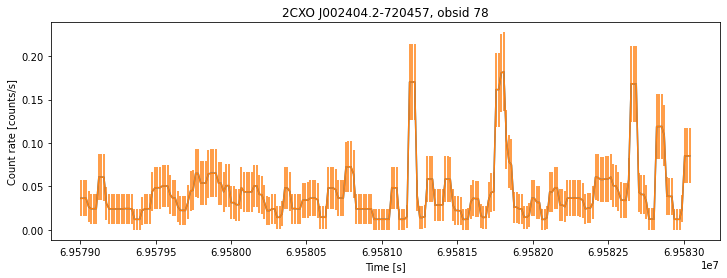

In [37]:
lc3 = hdul[1].data
bg3 = hdul[2].data
plt.subplots(figsize=(12, 4))
plt.plot(lc3['Time'],lc3['COUNT_RATE'])
plt.errorbar(lc3['Time'],lc3['COUNT_RATE'],lc3['COUNT_RATE_ERR'])

plt.xlabel('Time [s]')
plt.ylabel('Count rate [counts/s]')
plt.title('2CXO J002404.2-720457, obsid 78')

This variable source has an interesting light curve (as determined using the [Gregory-Loredo algorithm](https://cxc.cfa.harvard.edu/csc/why/gregory_loredo.html)). The light curve shows clear flickering/flaring behavior. In fact, if we investigate, further, we realize that this source correspond to [a magnetic cataclysmic variable](https://ui.adsabs.harvard.edu/abs/2001Sci...292.2290G/abstract) in the globular cluster 47 Tuc.

We can also visualize the catalog spectra we downloaded for this source using Sherpa (and then do with it all the cool spectral fitting that you have seen in the BXA tutorials, and that you will see in the Sherpa tutorials):

In [38]:
from sherpa.astro import ui
ui.load_pha('/Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N022_r0058_pha3.fits.gz')

read ARF file /Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N021_r0058_arf3.fits
read RMF file /Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N021_r0058_rmf3.fits
read background file /Users/juan/L3/tutorial/2CXOJ002404.2-720457/00078_000/acisf00078_000N022_r0058_pha3.fits


Let's restrict the energy range, and also bin the counts in constructing the spectrum.

In [39]:
ui.notice_id(1,0.3,7.)
ui.group_counts(10)

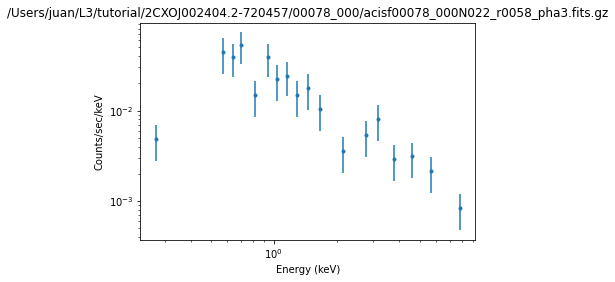

In [40]:
ui.set_ylog()
ui.set_xlog()
ui.plot_data()

## Cross-matching the CSC2 with other catalogs

Now we will explore how to cross-match the catalog with other catalogs for multi-wavelenght analysis. For this section, I used inspiration from Adrian Price-Whelan's [tutorial](https://learn.astropy.org/rst-tutorials/4-Coordinates-Crossmatch) on astropy cross-matching. Here we will use the 2MASS catalog to explore the infrared and X-ray properties of sources in the Orion nebula. Let's start by doing a cone search to select CSC2 sources in the Orion nebula, just as we have done before with M33:

In [41]:
M42 = SkyCoord.from_name('M42')
maxrad = 5.0 * u.arcmin
results = cone.search(pos=M42, radius=maxrad)
print('Your query resulted in ',len(results),'CSC2 sources')

Your query resulted in  927 CSC2 sources


Now let's use the astroquery to search Vizier for 2MASS sources:

In [42]:
from astroquery.vizier import Vizier
# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246", columns=['*', 'Date'])
v.ROW_LIMIT = -1

result = v.query_region(M42, radius=maxrad)
tmass_table = result[0]
print('Your query resulted in ',len(result[0]),'2MASS sources')

Your query resulted in  1368 2MASS sources


In [43]:
# The first 10 objects in the 2MASS query
tmass_table[0:10]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg,Date
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,,
float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8,bytes10
83.788731,-5.440881,05350929-0526271,14.772,--,15.353,0.257,12.972,--,UDU,020,010,0c0,2,0,2000-11-24
83.785823,-5.438737,05350859-0526194,13.240,0.032,12.317,0.033,11.764,0.024,AAA,222,111,000,1,0,2000-11-24
83.788837,-5.446417,05350932-0526471,14.318,--,13.601,--,14.812,0.184,UUC,002,001,000,2,0,2000-11-24
83.789403,-5.440359,05350945-0526252,13.423,--,11.918,--,14.070,0.113,UUB,002,001,00c,2,0,2000-11-24
83.789565,-5.463578,05350949-0527488,11.173,--,11.348,0.030,10.563,0.018,UEE,022,011,0cc,0,0,2000-11-24
83.789992,-5.466659,05350959-0527599,12.909,0.136,12.147,0.143,11.662,0.109,BBB,222,111,ccc,0,0,2000-11-24
83.790221,-5.439822,05350965-0526233,13.115,0.039,11.565,0.041,10.510,0.024,AAA,222,111,000,2,0,2000-11-24
83.790993,-5.464779,05350983-0527532,7.743,0.024,7.636,0.047,7.472,0.020,AAA,111,111,000,0,0,2000-11-24


Let's get the coordinates from the 2MASS catalog

In [44]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'],
                        tmass_table['DEJ2000'])

And the coordinates from the table of CSC2 sources:

In [45]:
M42_coords_csc2 = SkyCoord(
    ra=results['ra']*u.deg,
    dec=results['dec']*u.deg)

Now let's perform the cross match using astropy's [*match_to_catalog_sky*](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.match_to_catalog_sky) tool, which is based on a nearest neighbors search:

In [46]:
idx_, sep2d_, _ = M42_coords_csc2.match_to_catalog_sky(
    tmass_coords)

Let's visualize the separations between matched sources. Note that this is a crowded field, with many nearest neighbors being incorrect matches. To mitigate this, let's choose only matches that belong to the small separation peak (i.e., those at less than 1 arcsec in separation) in the following two-peaked distribution:

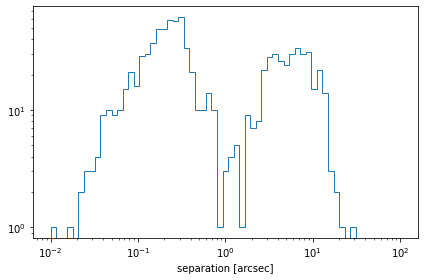

In [47]:
plt.hist(sep2d_.arcsec, histtype='step',
         bins=np.logspace(-2, 2., 64))
plt.xlabel('separation [arcsec]')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

We will create a color-hardness diagram, and an X-ray flux-IR magnitude diagram. Select the relevant properties from each table for only those matches with separations less than 1 arcsec:

In [48]:
Jmag1 = tmass_table['Jmag'][idx_][sep2d_.arcsec < 1.0]
Kmag1 = tmass_table['Kmag'][idx_][sep2d_.arcsec < 1.0]
flux_b1 = results['flux_aper_b'][sep2d_.arcsec < 1.0]
hard_hm1 = results['hard_hm'][sep2d_.arcsec < 1.0]

Let's only select objects where the X-ray flux is larger than 0.

In [49]:
Jmag = Jmag1[flux_b1>0]
Kmag = Kmag1[flux_b1>0]
flux_b = flux_b1[flux_b1>0]
hard_hm = hard_hm1[flux_b1>0]

Finally, let's visualize our diagrams:

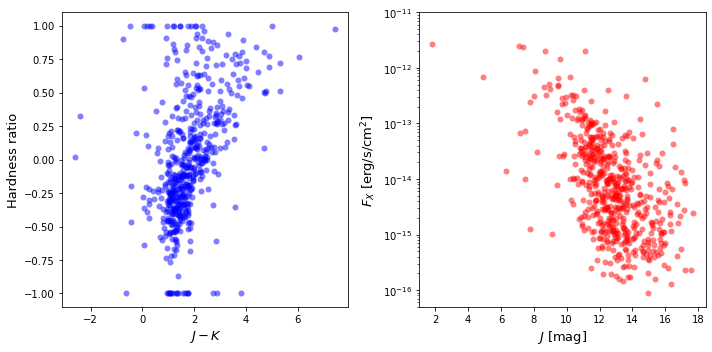

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Jmag - Kmag, hard_hm,
           marker='o', color='b',
           linewidth=0, alpha=0.5)
ax.set_xlabel('$J - K$',size=13)
ax.set_ylabel('Hardness ratio',size=13)
#ax.set_xlim(-1, 6)
#ax.set_ylim(19, 10) # backwards because magnitudes!

ax = axes[1]
ax.scatter(Jmag, flux_b,
           marker='o', color='r',
           linewidth=0, alpha=0.5)
ax.set_xlabel('$J$ [mag]',size=13)
ax.set_ylabel('$F_X$ [erg/s/cm$^2$]',size=13)
ax.set_yscale('log')
#ax.set_xlim(0.2, 1)
ax.set_ylim(5E-17, 1E-11) # backwards because magnitudes!

fig.tight_layout()

Looks like for young stellar objects, redder objects are also harder in X-rays. I am not an expert on this field, but perhaps hard X-ray flares resulting from magnetic reconnection in the surface of these stars are more common on YSO's where some of the redenning accretion disk is still detectable at near-IR wavelengths. Stars are also populating the expected locus of $F_x$ vs. $F_{NIR}$.

## Using your CSC2 data as input for a machine learning algorithm

Finally, let's see if we can input our cross-matched data to an algorithm for clustering using Scikit-learn. We will use the four quantities we have just plotted as the features for a K-means clustering algorithm that will try to separate astrophysical sources into clusters based on their properties, without associating them with any particular class (this is an unsupervised machine learning method).

In [51]:
from sklearn.cluster import KMeans

We need to get an array 'X' that will be the input to the clustering algorithm. This array is a list of 4 features (log of the X-ray flux, J-K color, J magnitude and the CSC2 hm hardness ratio) for each of the sources in our cross-matched list:

In [52]:
X = []
for i in range(len(Jmag)):
    X.append([Jmag[i],Jmag[i]-Kmag[i],np.log10(flux_b[i]),hard_hm[i]])
    
print(len(X))

554


Note that this dataset contains only 554 objects, and we are also going to arbitrarily select n=3 as the number of clusters into which we will separate those objects. So, please do not over-interpret the results, as they are most likely meaningless, or at most just marginally indicative. But you can refine this by including more objects, more features, and also by carefully selecting the number of clusters.

Because some of the fluxes and magnitudes can be not defined, this means that our dataset has missing data, which usually does not go well with standard machine learning algorihtms. A solution for this is data imputation, which replaces missing values (NaNs) with a certain value, for example, the mean of the distribution for the corresponding feature. You can do this data imputation easily with scikit-learn:

In [55]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
X_imputed = imp_mean.transform(X)

Now, let's fit the K-means model to the imputed data:

In [57]:
y_pred = KMeans(n_clusters=3, random_state=None).fit_predict(X_imputed)

Text(0, 0.5, 'log (Fx)')

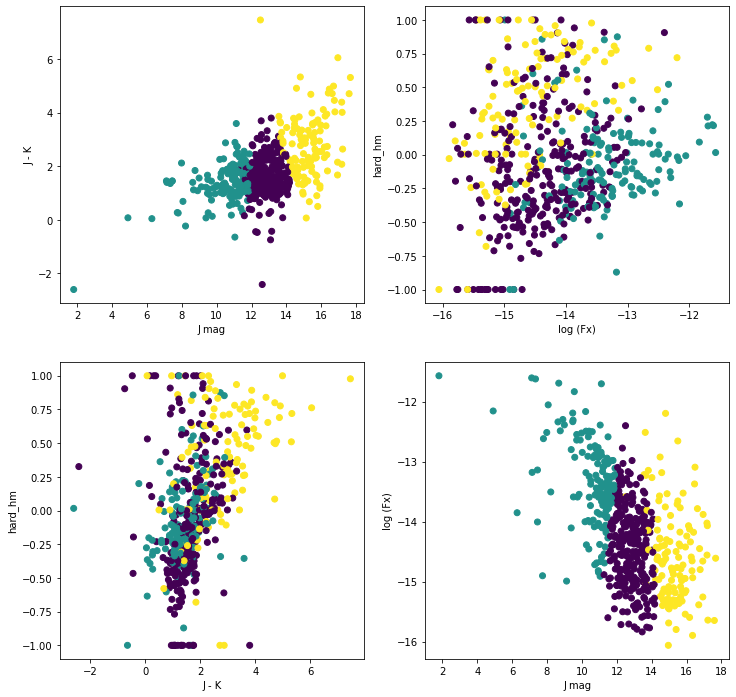

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
plt.subplot(221)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y_pred)
plt.xlabel('J mag')
plt.ylabel('J - K')
plt.subplot(222)
plt.scatter(X_imputed[:, 2], X_imputed[:, 3], c=y_pred)
plt.xlabel('log (Fx)')
plt.ylabel('hard_hm')
plt.subplot(223)
plt.scatter(X_imputed[:, 1], X_imputed[:, 3], c=y_pred)
plt.xlabel('J - K')
plt.ylabel('hard_hm')
plt.subplot(224)
plt.scatter(X_imputed[:, 0], X_imputed[:, 2], c=y_pred)
plt.xlabel('J mag')
plt.ylabel('log (Fx)')


It looks like the K-means algorithm separated the sources based mainly on how bright they are in the near-IR and X-ray bands, but it also took into account some information about the IR color and X-ray hardness ratio.